## Intro

This is a silly project that started with me and my brothers watching overwatch league matches and complaining about how terrible the casters are at filling time. I was looking for a new data science personal project and figured why not try and solve our problem with machine learning. In this notebook, I've written a convolutiuon neurel network to identify gameplay and skip all other parts of the match. It actually works pretty well. [here](https://www.ndled.us/stats/2021/08/06/CV-OWL.html) is a link to me rambling about my process for the first version I put up on github

Things I read while doing this

1) http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/

2) https://www.udemy.com/course/machinelearning/learn/lecture/6761136

3) https://www.toptal.com/machine-learning/machine-learning-video-analysis

4) https://www.analyticsvidhya.com/blog/2018/09/deep-learning-video-classification-python/

5) https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/


In [1]:
import cv2
import math
import pandas as pd
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize
import tensorflow as tf
from moviepy.editor import *
from keras.preprocessing.image import ImageDataGenerator
import subprocess
import matplotlib.pyplot as plt
import youtube_dl

In [2]:
def download(url):
    ydl_opts = {'format': 'bestvideo[ext=mp4]+bestaudio/best'}
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download= True)
        filename = ydl.prepare_filename(info)
    return filename

In [3]:
def video_cut(videoFile, imgname):
    count = 0
    cap = cv2.VideoCapture(videoFile)
    frameRate = cap.get(5)
    while(cap.isOpened()):
        frameId = cap.get(1)
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            name ="" + imgname + str(count).zfill(5) + ".jpg";count+=1
            cv2.imwrite(name, frame)
        print("working on frame " + str(count), end='\r')
    cap.release()
    print("")
    print ("Done!")

## Cutting Up Train Videos Into Frames

In [4]:
# videoCut('@Chengdu Hunters vs @Dallas Fuel _ Summer Showdown Tournament _ Day 1-5kVvsQYk2I0.mp4',
#          'train/1train_')
# videoCut('Losers Semi-Final _ @ATL Reign   vs   @Dallas Fuel _ Summer Showdown Tournament _ Day 2-RKKXYefOz5w.mp4',
#          'train/2train_')
# videoCut('Winners Finals _ @Chengdu Hunters vs  @Shanghai Dragons  _ Summer Showdown Tournament _ Day 2-hyCOml7JcrA.mp4',
#          'train/3train_')
# videoCut('Losers Finals _ @Chengdu Hunters vs @Dallas Fuel  _ Summer Showdown Tournament _ Day 2-dFcIIRQLbpo.mp4',
#          'train/4train_')

From here, I manually sorted as gameplay vs not gameplay

## Loading In Video to Process

In [5]:
url = "https://youtu.be/Z9B5gMWuBrg"
filename = download(url)

[youtube] Z9B5gMWuBrg: Downloading webpage
[download] Destination: @Seoul Dynasty vs @Philadelphia Fusion  _ Countdown Cup Knockouts _ Week 3 Day 3 — East-Z9B5gMWuBrg.f299.mp4
[download] 100% of 3.94GiB in 24:51                          
[download] Destination: @Seoul Dynasty vs @Philadelphia Fusion  _ Countdown Cup Knockouts _ Week 3 Day 3 — East-Z9B5gMWuBrg.f140.m4a
[download] 100% of 119.32MiB in 01:05                   
[ffmpeg] Merging formats into "@Seoul Dynasty vs @Philadelphia Fusion  _ Countdown Cup Knockouts _ Week 3 Day 3 — East-Z9B5gMWuBrg.mp4"
Deleting original file @Seoul Dynasty vs @Philadelphia Fusion  _ Countdown Cup Knockouts _ Week 3 Day 3 — East-Z9B5gMWuBrg.f299.mp4 (pass -k to keep)
Deleting original file @Seoul Dynasty vs @Philadelphia Fusion  _ Countdown Cup Knockouts _ Week 3 Day 3 — East-Z9B5gMWuBrg.f140.m4a (pass -k to keep)


In [6]:
video_cut(filename,"pred/images/8train_")

working on frame 7854
Done!


## Data Preprocessing

In [7]:
image_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split=.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = image_generator.flow_from_directory(batch_size=32,
                                                 directory='train',
                                                 shuffle=True,
                                                 target_size=(64, 64), 
                                                 subset="training",
                                                 class_mode='binary')
test_set = image_generator.flow_from_directory(batch_size=32,
                                                 directory='train',
                                                 shuffle=True,
                                                 target_size=(64, 64), 
                                                 subset="validation",
                                                 class_mode='binary')

Found 44504 images belonging to 2 classes.
Found 11125 images belonging to 2 classes.


## Building the CNN

In [8]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Training the CNN

In [9]:
cnn.compile(optimizer = 'adam',
            loss = 'binary_crossentropy',
            metrics = [tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.FalsePositives()])

In [10]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]      # model check pointing based on validation loss

In [11]:
history = cnn.fit(x = training_set, validation_data = test_set, epochs = 25, batch_size = 32, callbacks=callbacks_list)

Epoch 1/25
1391/1391 [==============================] - 758s 544ms/step - loss: 0.0706 - binary_accuracy: 0.9802 - false_negatives: 416.0000 - false_positives: 466.0000 - val_loss: 0.0638 - val_binary_accuracy: 0.9852 - val_false_negatives: 13.0000 - val_false_positives: 152.0000

Epoch 00001: val_loss improved from inf to 0.06382, saving model to weights.best.hdf5
Epoch 2/25
1391/1391 [==============================] - 636s 457ms/step - loss: 0.0370 - binary_accuracy: 0.9910 - false_negatives: 214.0000 - false_positives: 187.0000 - val_loss: 0.1086 - val_binary_accuracy: 0.9718 - val_false_negatives: 6.0000 - val_false_positives: 308.0000

Epoch 00002: val_loss did not improve from 0.06382
Epoch 3/25
1391/1391 [==============================] - 640s 460ms/step - loss: 0.0307 - binary_accuracy: 0.9926 - false_negatives: 182.0000 - false_positives: 149.0000 - val_loss: 0.0498 - val_binary_accuracy: 0.9899 - val_false_negatives: 6.0000 - val_false_positives: 106.0000

Epoch 00003: val_lo

1391/1391 [==============================] - 641s 460ms/step - loss: 0.0093 - binary_accuracy: 0.9968 - false_negatives: 77.0000 - false_positives: 67.0000 - val_loss: 0.0513 - val_binary_accuracy: 0.9935 - val_false_negatives: 3.0000 - val_false_positives: 69.0000

Epoch 00025: val_loss did not improve from 0.03083


In [12]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

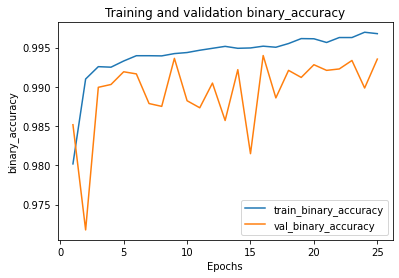

In [13]:
plot_metric(history, 'binary_accuracy')

### Saving/Loading the model

In [14]:
cnn.save_weights("model.h5")

In [73]:
cnn.load_weights("model.h5")

## Preprocessing Test Data

going to try and use flow from directory

In [15]:
image_generator2 = ImageDataGenerator(rescale = 1./255)

test_generator = image_generator2.flow_from_directory(batch_size=1,
                                                 directory='pred/',
                                                 target_size=(64, 64), 
                                                 class_mode=None,
                                                 shuffle = False)

Found 7854 images belonging to 1 classes.


## Predictions

In [16]:
pred_probs=cnn.predict_generator(test_generator, steps=len(test_generator), verbose=1)

7854/7854 [==============================] - 163s 21ms/step


In [17]:
pred_probs[:10]

array([[6.8474382e-02],
       [6.7119509e-02],
       [6.8026304e-02],
       [5.1489770e-03],
       [2.5724332e-05],
       [7.8156145e-06],
       [3.1818867e-01],
       [3.6668086e-01],
       [6.5127909e-03],
       [1.5047193e-04]], dtype=float32)

In [18]:
pred_bin=(pred_probs>0.5).astype("int32")

So, I want some sort of averaging here. Rolling average 

In [19]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

## Turning Predictions Into Something Workable

In [20]:
test_pred = (moving_average(pred_bin.ravel(),60)>.5).astype("int32")

In [21]:
test_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
times = []
for i in range(0,len(test_pred)):
    if test_pred[i] == 1:
        times.append(i)

In [23]:
times[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [24]:
count = 0
start_stop = []
for i in range(0,len(times)-1):
    if times[i] == times[i+1]-1:
        count = count + 1
    else:
        start_stop.append((times[i]-count,times[i]))
        count = 0
start_stop

[(0, 15),
 (149, 515),
 (770, 1128),
 (1844, 3070),
 (3532, 4738),
 (5273, 5870),
 (6398, 7268),
 (7411, 7488),
 (7567, 7659)]

So the start and stop times are much more readable, but game play within a couple of minutes shouldn't be in different groups

In [25]:
def combine_clips(start_stop):
    reduced = [start_stop[0]]
    for t in start_stop:
        if t[0] - reduced[-1][1] < 180:
            reduced[-1] = (reduced[-1][0],t[1])
        else:
            reduced.append(t)
    return reduced

In [26]:
reduced = combine_clips(start_stop)
reduced

[(0, 515), (770, 1128), (1844, 3070), (3532, 4738), (5273, 5870), (6398, 7659)]

Looking up above we are doing much better, but we might have a clip with tiny length, so lets make a section of code that clears anything less than 60 seconds (highlight video length)

In [27]:
final_time = []
for item in reduced:
    if item[1]-item[0] > 120:
        final_time.append(item)
final_time

[(0, 515), (770, 1128), (1844, 3070), (3532, 4738), (5273, 5870), (6398, 7659)]

## Writting Out Movie

In [28]:
def ffmpeg_time_format(final_time):
    select_text = "'"
    for i in range(0,len(final_time)):
        select_text = select_text+"between(t,"+str(final_time[i][0]-30)+","+str(final_time[i][1]+30)+")"
        if i < len(final_time)-1:
            select_text = select_text + "+"
    select_text = select_text + "'"
    return select_text

In [29]:
def cut(video,final_time,out):
    command = "ffmpeg -i \"{video}\" -vf \"select={select_text}, setpts=N/FRAME_RATE/TB\" -af \"aselect={select_text}, asetpts=N/SR/TB\" {out}.mp4".format(video=video, select_text=ffmpeg_time_format(final_time), out=out)
    #subprocess.call(command,shell=True)
    print(command)


In [ ]:
Cut(filename,final_time, "out")

## Depricated - Moviepy method

In [ ]:
# clip = VideoFileClip(videoFile)
# final = concatenate([clip.subclip(max(final_time[i][0]-30,0), min(final_time[i][1]+30,clip.duration)) for i in range(0,len(final_time))])
# final.to_videofile('test3.mp4')

## Next Steps

~~1) Setup image generator for the predictions. Right now this takes an ungodly amount of ram~~

~~2) Make a callout for youtube.dl to run everything from this one notebook~~

~~3) Add more trainning Data~~

~~4) Increase the number of Epochs for the CNN - once I stop adding to the training data~~

5) Add in layer graphics

~~6) Add higher weights for not gameplay time~~

7) Build a progress bar for cutting up the images

~~9) Switch over to ffmpeg, maybe, Working on this now and I'm not getting a time advantage.~~

~~10) Work on optimizing speed fpr ffmpeg, accept some lower quality~~

~~11) Build a CLT~~

12) Build cleanup function

13) Setup better path handling

14) Automate pulling with a web scrapper